# Question 1

In this question we will
- Practice reading image filenames from a .csv file for processing.
- Compare the PSNR and SSIM of different denoising methods applied to a dataset at different noise levels.




In [1]:
# Boilerplate imports
import skimage.io as skio
import skimage.color as skcolor
import skimage.util as skutil
import skimage.restoration as skrest
import skimage.filters as skfilt
import skimage.metrics as skmetrics
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Step 1: Read the image filenames from the .csv file.  

For this you should add `import pandas as pd` to the list of boilerplate imports, above.  Then use the pd.read_csv() function and give the path to the images.csv file as an argument, and also give the optional argument `headers=None` because the given .csv file does not have column title headers.  This will return a Pandas dataframe with one column containing the filenames.  We could iterate over the dataframe, but in order to not have to get too deep into the use of Pandas dataframes, we can convert the single column dataframe to a Python list easily.  If the dataframe is referred to by a variable called `files`, we can convert the first column to a list using:  `files[0].tolist()`.  This will return a list of strings, one for each filename that we can now easily iterate over using a for-loop.


In [2]:
# Write the code for this step here
# image_files = pd.read_csv("/u1/cmpt487-819/data/asn1/images.csv", header=None)
image_files = pd.read_csv("images.csv", header=None)
file_list = image_files[0].tolist()

# for name in file_names:
#     print(name)


# Step 2: Process the images

## Instructions

- For each filename in `file_list` defined in the prevous block (for testing purposes you can use a small number of the images, say the first 3-5 filenames):
    - read in the noiseless version of that image from the images/noiseless directory.  Convert it to grayscale (since these are RGB colour images) and convert it to a dtype float64 numpy array using `skutil.img_as_float()`.
    - use the `skutil.random_noise()` function to corrupt the noiseless image with Gaussian noise with standard deviation sigma for each of the sigma values given in the array `sigmas`, defined below.  Keep in mind that the values in `sigmas` are standard deviations, and the `random_noise()` function expects *variance*, so you will need to square the sigma values when you pass them to `random_noise()`.
    - Denoise each of the 5 noisy versions of the image with Gaussian filtering (`skfilt.gaussian()`), total variation minimization (TVM) (`skrest.denoise_tv_bregman()`), and non-local means filtering (NLM) (`skrest.denoise_nl_means()`).  For Gaussian filtering, use a 7x7 filter.  For TVM and NLM just pass in the image and use the *default* parameters.
    - For each denoised image, compute and store the PSNR and SSIM resulting from denoising with each method by comparing each denoised image to the noiseless image.  Do this in such a way that is easy to compute the averages described below.
      
- Compute the average PSNR and SSIM for each denoising method and noise level.   We recommend that the results of this computation be stored in the form of six different arrays or lists, one for each combination of denoising method and metric.
- See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()` to compute PSNR and SSIM.

For testing use only the first three to five filenames in `file_list` so that you can perform testing quickly.  Once you have completed and thoroughly tested your code, run it on the entire list of filenames.  This will take several minutes.  


In [3]:
# Define the set of different noise levels.  Remember these are STANDARD DEVIATIONS, not VARIANCE. The squares of these values are variance.
sigmas = [0.01, 0.02, 0.05, 0.1, 0.2]

# first_n = min(5, len(file_list))
first_n = len(file_list)


# arrays to hold ssim and psnr values
psnr_gauss = np.zeros((len(sigmas), first_n))
ssim_gauss = np.zeros((len(sigmas), first_n))

psnr_tvb = np.zeros((len(sigmas), first_n))
ssim_tvb = np.zeros((len(sigmas), first_n))

psnr_nlm = np.zeros((len(sigmas), first_n))
ssim_nlm = np.zeros((len(sigmas), first_n))

# Write the code for the rest of this step here.
for i in range(first_n):
    imagename = file_list[i]
    # img_path = os.path.join("/u1/cmpt487-819/data/asn1/images/noiseless", imagename)
    img_path = os.path.join("images/noiseless", imagename)
    myimage = skio.imread(img_path)
    float_img =  skutil.img_as_float(myimage)
    gray = skcolor.rgb2gray(float_img)
    for j, sigma in enumerate(sigmas):
        noisy = skutil.random_noise(gray, mode='gaussian', var=(sigma ** 2))
        denoise_gauss = skfilt.gaussian(noisy, sigma=1.0, truncate=3.0, preserve_range=True)
        denoise_tvb = skrest.denoise_tv_bregman(noisy)
        denoise_nlm = skrest.denoise_nl_means(noisy)

        psnr_gauss[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_gauss, data_range=1.0)
        ssim_gauss[j, i] = skmetrics.structural_similarity(gray, denoise_gauss, data_range=1.0)

        psnr_tvb[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_tvb, data_range=1.0)
        ssim_tvb[j, i] = skmetrics.structural_similarity(gray, denoise_tvb, data_range=1.0)

        psnr_nlm[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_nlm, data_range=1.0)
        ssim_nlm[j, i] = skmetrics.structural_similarity(gray, denoise_nlm, data_range=1.0)
    print(f"Processed {i+1}/{first_n}: {imagename}")

avg_psnr_gauss = psnr_gauss.mean(axis=1)
avg_ssim_gauss = ssim_gauss.mean(axis=1)

avg_psnr_tvb = psnr_tvb.mean(axis=1)
avg_ssim_tvb = ssim_tvb.mean(axis=1)

avg_psnr_nlm = psnr_nlm.mean(axis=1)
avg_ssim_nlm = ssim_nlm.mean(axis=1)

print("\nAverage PSNR (dB) and SSIM for each method and sigma:")
print("{:>8} | {:>12} {:>8} | {:>12} {:>8} | {:>12} {:>8}".format(
    "sigma", "PSNR_Gauss", "SSIM_G", "PSNR_TVB", "SSIM_T", "PSNR_NLM", "SSIM_N"))
print("-" * 80)
for i, sigma in enumerate(sigmas):
    print("{:8.3f} | {:12.4f} {:8.4f} | {:12.4f} {:8.4f} | {:12.4f} {:8.4f}".format(
        sigma,
        avg_psnr_gauss[i], avg_ssim_gauss[i],
        avg_psnr_tvb[i], avg_ssim_tvb[i],
        avg_psnr_nlm[i], avg_ssim_nlm[i]
    ))

Processed 1/200: 100075.png
Processed 2/200: 100080.png
Processed 3/200: 100098.png
Processed 4/200: 103041.png
Processed 5/200: 104022.png
Processed 6/200: 105019.png
Processed 7/200: 105053.png
Processed 8/200: 106020.png
Processed 9/200: 106025.png
Processed 10/200: 108041.png
Processed 11/200: 108073.png
Processed 12/200: 109034.png
Processed 13/200: 112082.png
Processed 14/200: 113009.png
Processed 15/200: 113016.png
Processed 16/200: 113044.png
Processed 17/200: 117054.png
Processed 18/200: 118020.png
Processed 19/200: 118035.png
Processed 20/200: 12003.png
Processed 21/200: 12074.png
Processed 22/200: 122048.png
Processed 23/200: 124084.png
Processed 24/200: 126039.png
Processed 25/200: 130034.png
Processed 26/200: 134008.png
Processed 27/200: 134052.png
Processed 28/200: 135037.png
Processed 29/200: 135069.png
Processed 30/200: 138032.png
Processed 31/200: 138078.png
Processed 32/200: 140055.png
Processed 33/200: 140075.png
Processed 34/200: 144067.png
Processed 35/200: 145014.

# Step 3: Plot the PSNR and SSIM for each noise level and denoising method.

## Instructions

- Generate a 2 x 6 group of subplots, each of which contains a bar graph.  The first row of three graphs should show the mean PSNR for each of the five noise levels for Gaussian filtering, TVM filtering and NLM filtering.  Sample output is given in the assignment PDF.  Your plots, subplot titles, axis labels, and tick labels should match the sample output.
- Make sure that the range of the y-axis is the same for all PSNR plots and the same for all SSIM plots.


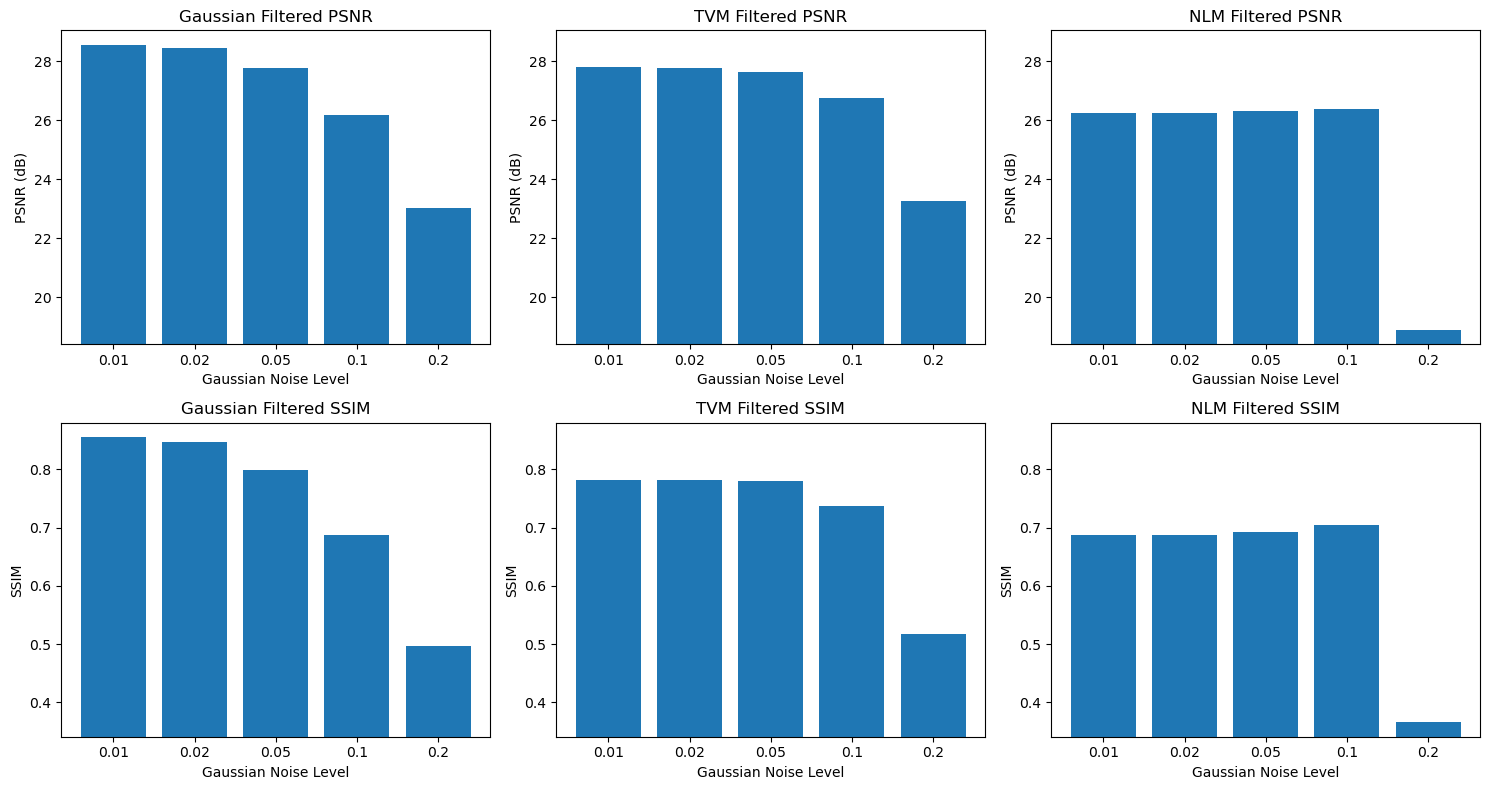

In [18]:
# Write the code for this step here
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

psnr_min = min(avg_psnr_gauss.min(), avg_psnr_tvb.min(), avg_psnr_nlm.min())
psnr_max = max(avg_psnr_gauss.max(), avg_psnr_tvb.max(), avg_psnr_nlm.max())
ssim_min = min(avg_ssim_gauss.min(), avg_ssim_tvb.min(), avg_ssim_nlm.min())
ssim_max = max(avg_ssim_gauss.max(), avg_ssim_tvb.max(), avg_ssim_nlm.max())

psnr_margin = 0.05 * (psnr_max - psnr_min)
ssim_margin = 0.05 * (ssim_max - ssim_min)

# --- PSNR row ---
axes[0,0].bar(range(len(sigmas)), avg_psnr_gauss, tick_label=[str(s) for s in sigmas])
axes[0,0].set_title("Gaussian Filtered PSNR")
axes[0,0].set_xlabel("Gaussian Noise Level")
axes[0,0].set_ylabel("PSNR (dB)")
axes[0,0].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

axes[0,1].bar(range(len(sigmas)), avg_psnr_tvb, tick_label=[str(s) for s in sigmas])
axes[0,1].set_title("TVM Filtered PSNR")
axes[0,1].set_xlabel("Gaussian Noise Level")
axes[0,1].set_ylabel("PSNR (dB)")
axes[0,1].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

axes[0,2].bar(range(len(sigmas)), avg_psnr_nlm, tick_label=[str(s) for s in sigmas])
axes[0,2].set_title("NLM Filtered PSNR")
axes[0,2].set_xlabel("Gaussian Noise Level")
axes[0,2].set_ylabel("PSNR (dB)")
axes[0,2].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

# --- SSIM row ---
axes[1,0].bar(range(len(sigmas)), avg_ssim_gauss, tick_label=[str(s) for s in sigmas])
axes[1,0].set_title("Gaussian Filtered SSIM")
axes[1,0].set_xlabel("Gaussian Noise Level")
axes[1,0].set_ylabel("SSIM")
axes[1,0].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

axes[1,1].bar(range(len(sigmas)), avg_ssim_tvb, tick_label=[str(s) for s in sigmas])
axes[1,1].set_title("TVM Filtered SSIM")
axes[1,1].set_xlabel("Gaussian Noise Level")
axes[1,1].set_ylabel("SSIM")
axes[1,1].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

axes[1,2].bar(range(len(sigmas)), avg_ssim_nlm, tick_label=[str(s) for s in sigmas])
axes[1,2].set_title("NLM Filtered SSIM")
axes[1,2].set_xlabel("Gaussian Noise Level")
axes[1,2].set_ylabel("SSIM")
axes[1,2].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

plt.tight_layout()
plt.show()

# Step 4: Reflection

We'd expect the total variation minimization (TVM) to be slightly better than Gaussian filtering at most noise levels, but we do not see this.  We'd also expect the non-local means (NLM) filtering to outperform Gaussian filtering at all noise levels, and again we do not see this.  This is because we did all filtering using default parameters for the TVM and NLM filtering algorithms.  Why do the default parameters not produce expected results?

### Type your answer here in this block:
As seen in the above graphs, the TVM and NLM filtering does not adapt well. This is because TVM uses weights as a parameter and NLM uses h (degree of filtering) as a parameter. The defaults for guassian works because the default values are sigma, and since sigma changes as the noise changes it has no issues, but for TVM and NLM we need to change the parameters in a similar manner to adjust to the noise and get better output.


# Step 5: Improving the Results

## Instructions:

- Investigate the documentation for the denoise_tv_bregman() and denoise_nl_means() functions.   
- Determine more optimal parameters for these algorithms that will improve results across all noise levels.  You may make the values of parameters dependent on the known noise level of a given image (i.e. a parameter may be a function of the noise level).
- Hint: you can likely copy your code from Steps 2 and 3 and then add parameters to the denoising algoirthms.  
- The output of this step should have the same form as Step 3, but the bar heights will be different.

By adjusting the algorithm parameters judiciously, it should be possible to get TVM to at least very slightly outperform Gaussian filtering at all noise levels, and it should be possible to get NLM to greatly outperform both Gaussian filtering and TVM at low noise levels, and perform at least as well at high noise levels.

This step will be assessed based on how closely you match or exceed the expected results described above (see rubric on Canvas).

Processed 1/200: 100075.png
Processed 2/200: 100080.png
Processed 3/200: 100098.png
Processed 4/200: 103041.png
Processed 5/200: 104022.png
Processed 6/200: 105019.png
Processed 7/200: 105053.png
Processed 8/200: 106020.png
Processed 9/200: 106025.png
Processed 10/200: 108041.png
Processed 11/200: 108073.png
Processed 12/200: 109034.png
Processed 13/200: 112082.png
Processed 14/200: 113009.png
Processed 15/200: 113016.png
Processed 16/200: 113044.png
Processed 17/200: 117054.png
Processed 18/200: 118020.png
Processed 19/200: 118035.png
Processed 20/200: 12003.png
Processed 21/200: 12074.png
Processed 22/200: 122048.png
Processed 23/200: 124084.png
Processed 24/200: 126039.png
Processed 25/200: 130034.png
Processed 26/200: 134008.png
Processed 27/200: 134052.png
Processed 28/200: 135037.png
Processed 29/200: 135069.png
Processed 30/200: 138032.png
Processed 31/200: 138078.png
Processed 32/200: 140055.png
Processed 33/200: 140075.png
Processed 34/200: 144067.png
Processed 35/200: 145014.

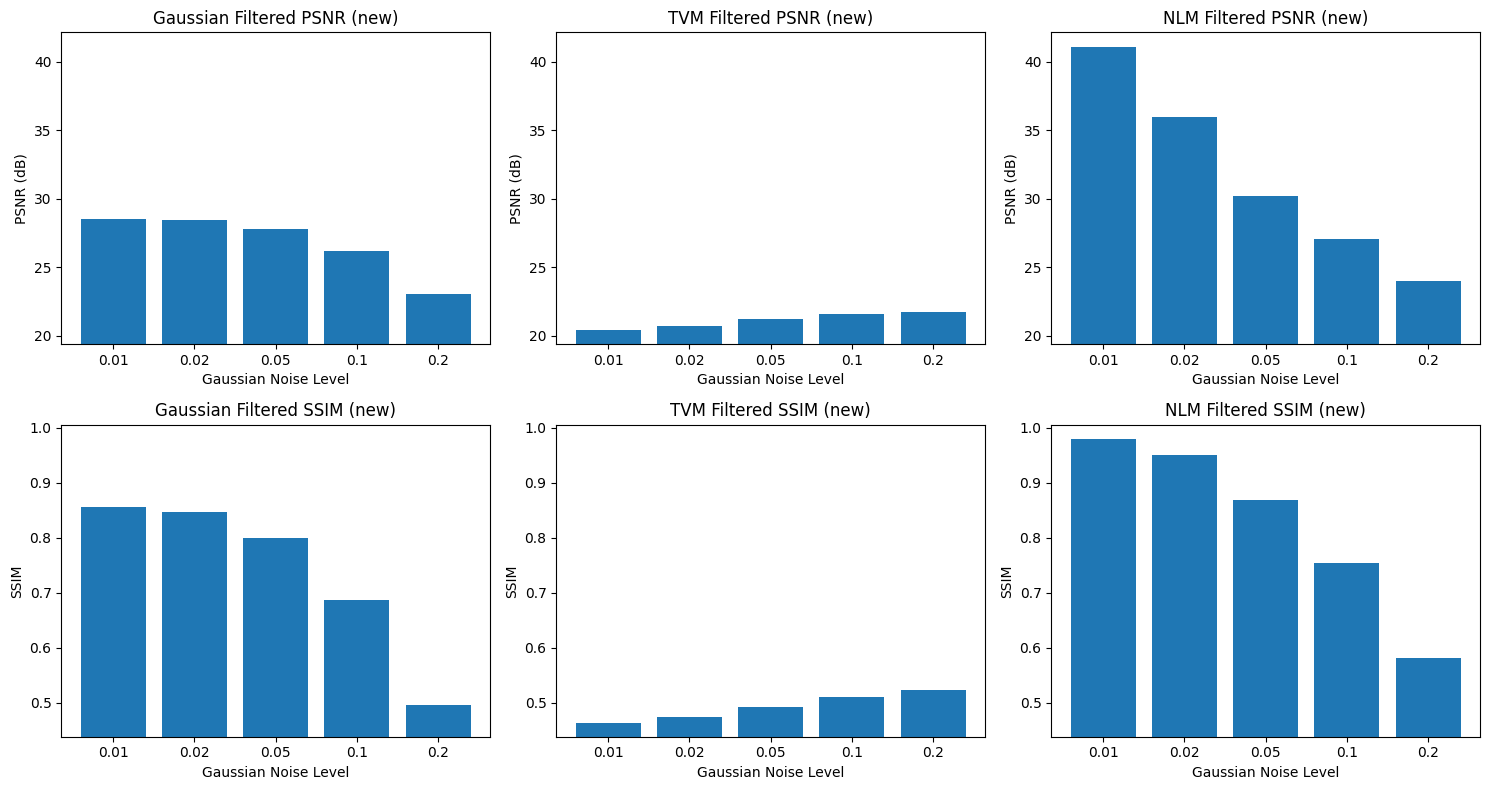

In [5]:
# Write the code for this step here
# Define the set of different noise levels.  Remember these are STANDARD DEVIATIONS, not VARIANCE. The squares of these values are variance.
sigmas = [0.01, 0.02, 0.05, 0.1, 0.2]

# first_n = min(5, len(file_list))
first_n = len(file_list)


# arrays to hold ssim and psnr values
psnr_gauss = np.zeros((len(sigmas), first_n))
ssim_gauss = np.zeros((len(sigmas), first_n))

psnr_tvb = np.zeros((len(sigmas), first_n))
ssim_tvb = np.zeros((len(sigmas), first_n))

psnr_nlm = np.zeros((len(sigmas), first_n))
ssim_nlm = np.zeros((len(sigmas), first_n))

# Write the code for the rest of this step here.
for i in range(first_n):
    imagename = file_list[i]
    img_path = os.path.join("images/noiseless", imagename)
    myimage = skio.imread(img_path)
    float_img =  skutil.img_as_float(myimage)
    gray = skcolor.rgb2gray(float_img)
    for j, sigma in enumerate(sigmas):
        noisy = skutil.random_noise(gray, mode='gaussian', var=(sigma ** 2))
        denoise_gauss = skfilt.gaussian(noisy, sigma=1.0, truncate=3.0, preserve_range=True)
        denoise_tvb = skrest.denoise_tv_bregman(noisy, weight=0.8*sigma)
        denoise_nlm = skrest.denoise_nl_means(noisy, h=0.7*sigma)

        psnr_gauss[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_gauss, data_range=1.0)
        ssim_gauss[j, i] = skmetrics.structural_similarity(gray, denoise_gauss, data_range=1.0)

        psnr_tvb[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_tvb, data_range=1.0)
        ssim_tvb[j, i] = skmetrics.structural_similarity(gray, denoise_tvb, data_range=1.0)

        psnr_nlm[j, i] = skmetrics.peak_signal_noise_ratio(gray, denoise_nlm, data_range=1.0)
        ssim_nlm[j, i] = skmetrics.structural_similarity(gray, denoise_nlm, data_range=1.0)
    print(f"Processed {i+1}/{first_n}: {imagename}")

avg_psnr_gauss = psnr_gauss.mean(axis=1)
avg_ssim_gauss = ssim_gauss.mean(axis=1)

avg_psnr_tvb = psnr_tvb.mean(axis=1)
avg_ssim_tvb = ssim_tvb.mean(axis=1)

avg_psnr_nlm = psnr_nlm.mean(axis=1)
avg_ssim_nlm = ssim_nlm.mean(axis=1)

print("\nAverage PSNR (dB) and SSIM for each method and sigma:")
print("{:>8} | {:>12} {:>8} | {:>12} {:>8} | {:>12} {:>8}".format(
    "sigma", "PSNR_Gauss", "SSIM_G", "PSNR_TVB", "SSIM_T", "PSNR_NLM", "SSIM_N"))
print("-" * 80)
for i, sigma in enumerate(sigmas):
    print("{:8.3f} | {:12.4f} {:8.4f} | {:12.4f} {:8.4f} | {:12.4f} {:8.4f}".format(
        sigma,
        avg_psnr_gauss[i], avg_ssim_gauss[i],
        avg_psnr_tvb[i], avg_ssim_tvb[i],
        avg_psnr_nlm[i], avg_ssim_nlm[i]
    ))

# Figures
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

psnr_min = min(avg_psnr_gauss.min(), avg_psnr_tvb.min(), avg_psnr_nlm.min())
psnr_max = max(avg_psnr_gauss.max(), avg_psnr_tvb.max(), avg_psnr_nlm.max())
ssim_min = min(avg_ssim_gauss.min(), avg_ssim_tvb.min(), avg_ssim_nlm.min())
ssim_max = max(avg_ssim_gauss.max(), avg_ssim_tvb.max(), avg_ssim_nlm.max())

psnr_margin = 0.05 * (psnr_max - psnr_min)
ssim_margin = 0.05 * (ssim_max - ssim_min)

# --- PSNR row ---
axes[0,0].bar(range(len(sigmas)), avg_psnr_gauss, tick_label=[str(s) for s in sigmas])
axes[0,0].set_title("Gaussian Filtered PSNR (new)")
axes[0,0].set_xlabel("Gaussian Noise Level")
axes[0,0].set_ylabel("PSNR (dB)")
axes[0,0].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

axes[0,1].bar(range(len(sigmas)), avg_psnr_tvb, tick_label=[str(s) for s in sigmas])
axes[0,1].set_title("TVM Filtered PSNR (new)")
axes[0,1].set_xlabel("Gaussian Noise Level")
axes[0,1].set_ylabel("PSNR (dB)")
axes[0,1].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

axes[0,2].bar(range(len(sigmas)), avg_psnr_nlm, tick_label=[str(s) for s in sigmas])
axes[0,2].set_title("NLM Filtered PSNR (new)")
axes[0,2].set_xlabel("Gaussian Noise Level")
axes[0,2].set_ylabel("PSNR (dB)")
axes[0,2].set_ylim(psnr_min - psnr_margin, psnr_max + psnr_margin)

# --- SSIM row ---
axes[1,0].bar(range(len(sigmas)), avg_ssim_gauss, tick_label=[str(s) for s in sigmas])
axes[1,0].set_title("Gaussian Filtered SSIM (new)")
axes[1,0].set_xlabel("Gaussian Noise Level")
axes[1,0].set_ylabel("SSIM")
axes[1,0].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

axes[1,1].bar(range(len(sigmas)), avg_ssim_tvb, tick_label=[str(s) for s in sigmas])
axes[1,1].set_title("TVM Filtered SSIM (new)")
axes[1,1].set_xlabel("Gaussian Noise Level")
axes[1,1].set_ylabel("SSIM")
axes[1,1].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

axes[1,2].bar(range(len(sigmas)), avg_ssim_nlm, tick_label=[str(s) for s in sigmas])
axes[1,2].set_title("NLM Filtered SSIM (new)")
axes[1,2].set_xlabel("Gaussian Noise Level")
axes[1,2].set_ylabel("SSIM")
axes[1,2].set_ylim(ssim_min - ssim_margin, ssim_max + ssim_margin)

plt.tight_layout()
plt.show()